In [ ]:
# ======================= Cell 1: Imports & Download (LSTM-ready) ======================= #
import os
import warnings
warnings.filterwarnings("ignore")

# --- Reproducibility ---
RANDOM_STATE = 42

import numpy as np
np.random.seed(RANDOM_STATE)

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(RANDOM_STATE)
from tensorflow.keras import layers, callbacks, optimizers, Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Download dataset via kagglehub (with fallback) ---
try:
    import kagglehub
except Exception:
    try:
        import sys, subprocess
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kagglehub"], check=True)
        import kagglehub
    except Exception as e:
        kagglehub = None
        print("⚠️ Không thể import kagglehub:", e)

if kagglehub is not None:
    try:
        path = kagglehub.dataset_download("ricgomes/global-fashion-retail-stores-dataset")
        print("Path to dataset files:", path)
    except Exception as e:
        path = ""
        print("⚠️ Không tải được dataset qua kagglehub. Hãy tải thủ công và gán biến `path` tới thư mục chứa CSV. Lỗi:", e)
else:
    path = ""
    print("⚠️ Kagglehub không khả dụng. Hãy tải thủ công và gán biến `path` tới thư mục chứa CSV.")

print("TensorFlow version:", tf.__version__)

Using Colab cache for faster access to the 'global-fashion-retail-stores-dataset' dataset.
Path to dataset files: /kaggle/input/global-fashion-retail-stores-dataset
TensorFlow version: 2.19.0


In [ ]:
# ======================= Cell 2: Load Transactions ======================= #
# Robustly find the Transactions file with different casings
CAND = ["Transactions.csv", "transactions.csv", "TRANSACTIONS.csv"]
tx_fp = None
for c in CAND:
    p = os.path.join(path, c)
    if os.path.exists(p):
        tx_fp = p
        break
if tx_fp is None:
    raise FileNotFoundError(
        f"Không tìm thấy file Transactions. Đặt lại tên file trong thư mục: {path}"
    )

df = pd.read_csv(tx_fp)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns)[:10], "...")

Loaded shape: (6416827, 19)
Columns: ['Invoice ID', 'Line', 'Customer ID', 'Product ID', 'Size', 'Color', 'Unit Price', 'Quantity', 'Date', 'Discount'] ...


In [ ]:
# ======================= Cell 3: Preprocessing (Currency → USD) ======================= #
import re

# 0) Config nhỏ
DROP_UNKNOWN_FX = False  # True = loại bỏ các dòng không nhận diện được tỷ giá

# 1) Chuẩn hóa tên cột
def norm_col(c):
    return str(c).strip().replace("\n", " ").replace("\r", " ")

df.columns = [norm_col(c) for c in df.columns]

# 2) Tên cột chuẩn
C_DATE        = "Date"
C_INV_ID      = "Invoice ID"
C_LINE_TOTAL  = "Line Total"
C_INV_TOTAL   = "Invoice Total"
C_UNIT_PRICE  = "Unit Price"
C_CCY         = "Currency"
C_CCY_SYM     = "Currency Symbol"

if C_DATE not in df.columns:
    raise ValueError(f"Thiếu cột '{C_DATE}' trong Transactions. Hiện có: {df.columns.tolist()}")

# 3) Parse Date
df[C_DATE] = pd.to_datetime(df[C_DATE], errors="coerce")
df = df.dropna(subset=[C_DATE]).copy()

# 4) Clean tiền tệ → số
def money_to_numeric(series):
    if series is None:
        return None
    s = pd.Series(series).astype(str)
    s = s.str.replace(r"[^\d\-\.,]", "", regex=True)  # giữ số, '-' '.' ','
    s = s.str.replace(",", "", regex=False)           # bỏ dấu phẩy nghìn
    return pd.to_numeric(s, errors="coerce")

# 5) Bảng FX (USD/1 đơn vị ngoại tệ) — cập nhật theo ngày tham chiếu của bạn nếu cần
FX_USD = {
    "USD": 1.00, "EUR": 1.08, "GBP": 1.25, "JPY": 0.0068, "CNY": 0.14,
    "AUD": 0.66, "CAD": 0.73, "CHF": 1.10, "SGD": 0.74, "HKD": 0.13,
    "MXN": 0.055, "BRL": 0.20, "INR": 0.012, "KRW": 0.00075, "TWD": 0.031,
    "THB": 0.027, "VND": 0.000041, "PLN": 0.25, "SEK": 0.091, "NOK": 0.093,
    "DKK": 0.145, "TRY": 0.033, "AED": 0.272, "ZAR": 0.053, "RUB": 0.011,
}

# Ký hiệu → mã CCY (mặc định '¥' là JPY; đổi nếu dữ liệu của bạn là CNY)
SYMBOL_TO_CCY = {
    "$": "USD", "US$": "USD", "€": "EUR", "£": "GBP",
    "¥": "JPY", "CN¥": "CNY", "฿": "THB", "₫": "VND", "₩": "KRW",
    "A$": "AUD", "C$": "CAD", "S$": "SGD", "HK$": "HKD", "R$": "BRL",
    "₹": "INR", "zł": "PLN", "Fr": "CHF", "CHF": "CHF", "₺": "TRY",
    "AED": "AED", "MX$": "MXN",
}

def normalize_currency(row):
    code = str(row.get(C_CCY, "")).strip().upper()
    sym  = str(row.get(C_CCY_SYM, "")).strip()
    if code in FX_USD:  # đã là ISO-3
        return code
    guess = re.sub(r"[^A-Z]", "", code)
    if guess in FX_USD:
        return guess
    if sym in SYMBOL_TO_CCY:
        return SYMBOL_TO_CCY[sym]
    return "USD"  # fallback

# 6) Xác định mã và tỷ giá
if (C_CCY in df.columns) or (C_CCY_SYM in df.columns):
    df["Currency_norm"] = df.apply(normalize_currency, axis=1)
else:
    df["Currency_norm"] = "USD"

rate = df["Currency_norm"].map(FX_USD)

# (tuỳ chọn) loại bỏ dòng không map được FX
if DROP_UNKNOWN_FX:
    bad = df[rate.isna()]
    if len(bad):
        print(f"Loại {len(bad)} dòng vì không map được FX: {sorted(bad['Currency_norm'].unique())}")
    df = df[~rate.isna()].copy()
    rate = df["Currency_norm"].map(FX_USD)

# Nếu vẫn còn NaN → dùng 1.0 và cảnh báo
if rate.isna().any():
    unk = sorted(df.loc[rate.isna(), "Currency_norm"].unique())
    print("⚠️  Không có tỷ giá cho:", unk, "→ dùng 1.0 (không đổi). Hãy bổ sung FX_USD nếu cần.")
    rate = rate.fillna(1.0)

# 7) Quy đổi sang USD tại chỗ
for col in [C_LINE_TOTAL, C_INV_TOTAL, C_UNIT_PRICE]:
    if col in df.columns:
        df[col] = money_to_numeric(df[col]) * rate.values

df["Currency_USD_rate"] = rate.values
df["Currency_standard"] = "USD"

print("Currency_norm (ví dụ):", df["Currency_norm"].dropna().unique()[:10])
print("Đã quy đổi các cột tiền về USD:", [c for c in [C_LINE_TOTAL, C_INV_TOTAL, C_UNIT_PRICE] if c in df.columns])


Currency_norm (ví dụ): ['USD' 'CNY' 'EUR' 'GBP']
Đã quy đổi các cột tiền về USD: ['Line Total', 'Invoice Total', 'Unit Price']


In [ ]:
# ======================= Cell 4: Build Daily Revenue (USD) ======================= #
C_DATE       = "Date"
C_INV_ID     = "Invoice ID"
C_LINE_TOTAL = "Line Total"     # đã là USD sau Cell 3
C_INV_TOTAL  = "Invoice Total"  # đã là USD sau Cell 3

# Sanity-check: mọi dòng đều đã gắn chuẩn USD
if "Currency_standard" in df.columns:
    assert (df["Currency_standard"] == "USD").all(), "Phát hiện dòng chưa chuẩn USD!"

# Cách A: sum(Line Total) theo ngày
daily_A = None
if C_LINE_TOTAL in df.columns:
    daily_A = (
        df.groupby(df[C_DATE].dt.date)[C_LINE_TOTAL]
          .sum()
          .rename("revenue_A_line_sum_usd")
          .to_frame()
    )

# Cách B: sum(Invoice Total) theo ngày (mỗi hóa đơn 1 lần)
daily_B = None
if C_INV_TOTAL in df.columns and C_INV_ID in df.columns:
    inv_level = (
        df.groupby([C_INV_ID], as_index=False)
          .agg({C_INV_TOTAL:"max", C_DATE:"min"})
    )
    daily_B = (
        inv_level.groupby(inv_level[C_DATE].dt.date)[C_INV_TOTAL]
                 .sum()
                 .rename("revenue_B_invoice_sum_usd")
                 .to_frame()
    )

if daily_A is None and daily_B is None:
    raise ValueError("Thiếu cả 'Line Total' và 'Invoice Total' để tính doanh thu ngày (USD).")

# So sánh & chọn
if daily_A is not None and daily_B is not None:
    joined = daily_A.join(daily_B, how="outer").fillna(0.0)
    denom = np.where(joined["revenue_B_invoice_sum_usd"] == 0, 1.0, joined["revenue_B_invoice_sum_usd"])
    rel_diff = np.abs(joined["revenue_A_line_sum_usd"] - joined["revenue_B_invoice_sum_usd"]) / denom
    mean_rel_diff = float(rel_diff.mean())
    print(f"Chênh lệch A vs B (USD): {mean_rel_diff:.2%}")

    if mean_rel_diff > 0.05:
        print("⚠️  >5% → dùng CÁCH A (sum Line Total, USD).")
        daily = joined[["revenue_A_line_sum_usd"]].rename(columns={"revenue_A_line_sum_usd":"revenue"})
    else:
        daily = joined[["revenue_B_invoice_sum_usd"]].rename(columns={"revenue_B_invoice_sum_usd":"revenue"})
else:
    daily = (daily_A or daily_B).rename(columns=lambda c: "revenue")

# Chuẩn hóa index ngày liên tục
daily.index = pd.to_datetime(daily.index)
daily = daily.sort_index()
full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
daily = daily.reindex(full_idx, fill_value=0.0)
daily.index.name = "date"

print("Doanh thu ngày (USD) — ví dụ:")
display(daily.head())


Chênh lệch A vs B (USD): 0.60%
Doanh thu ngày (USD) — ví dụ:


,revenue
date,
2023-01-01,741025.3150
2023-01-02,172046.9144
2023-01-03,154395.8828
2023-01-04,159579.5419
2023-01-05,152879.7995


In [ ]:
# ======================= Cell 5 (LSTM): Make supervised sequences ======================= #
# Mục tiêu: Dự báo y(t) từ chuỗi (t-WIN ... t-1) của [revenue và ngoại sinh]
# - Dùng exogenous: dow, dom, month, is_weekend
# - Chuẩn hoá bằng MinMaxScaler (fit trên train sau khi chia ở Cell 7)

WIN = 30        # độ dài cửa sổ quá khứ (có thể chỉnh 14/30/60)
HORIZON = 1     # dự báo ngày kế tiếp (1-step ahead)

# 1) Tạo dataframe theo ngày với revenue và đặc trưng lịch
df_seq = daily.copy()  # daily['revenue'] đã là USD từ Cell 4
df_seq = df_seq.rename(columns={"revenue": "y"})
df_seq["dow"] = df_seq.index.dayofweek
df_seq["dom"] = df_seq.index.day
df_seq["month"] = df_seq.index.month
df_seq["is_weekend"] = (df_seq["dow"] >= 5).astype(int)

feature_cols = ["y", "dow", "dom", "month", "is_weekend"]  # 'y' cũng dùng làm tín hiệu trong chuỗi quá khứ

# 2) Tạo sequences (X: [samples, WIN, n_features], y: [samples])
def build_sequences(df_seq, feature_cols, target_col, win=30, horizon=1):
    F = df_seq[feature_cols].values.astype("float32")
    y = df_seq[target_col].values.astype("float32")
    dates = df_seq.index

    X_list, y_list, tgt_idx = [], [], []
    T = len(df_seq)
    # Cửa sổ quá khứ dùng các mốc t-win ... t-1, dự báo y tại t+horizon-1 (ở đây horizon=1 nên là t)
    for t in range(win, T - horizon + 1):
        X_list.append(F[t - win:t, :])
        y_list.append(y[t + horizon - 1])
        tgt_idx.append(dates[t + horizon - 1])

    X = np.stack(X_list) if X_list else np.empty((0, win, len(feature_cols)), dtype="float32")
    y = np.array(y_list, dtype="float32")
    tgt_idx = np.array(tgt_idx)
    return X, y, tgt_idx

X_all_seq, y_all_seq, target_index = build_sequences(df_seq, feature_cols, "y", win=WIN, horizon=HORIZON)

print("X_all_seq shape:", X_all_seq.shape)  # (n_samples, WIN, n_features)
print("y_all_seq shape:", y_all_seq.shape)  # (n_samples,)
print("Target index sample:", target_index[:3])


X_all_seq shape: (778, 30, 5)
y_all_seq shape: (778,)
Target index sample: [Timestamp('2023-01-31 00:00:00') Timestamp('2023-02-01 00:00:00')
 Timestamp('2023-02-02 00:00:00')]


In [ ]:
# ======================= Cell 6: Metrics ======================= #
def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < 1e-8, 1.0, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom < 1e-8, 1.0, denom)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def evaluate(y_true, y_pred):
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAPE%": float(mape(y_true, y_pred)),
        "sMAPE%": float(smape(y_true, y_pred)),
    }

In [ ]:
# ======================= Cell (LSTM Final – 64_32_do0_mae) ======================= #
# Chạy cell này sau khi Cell 1–5 (đã tạo X_all_seq, y_all_seq, target_index) chạy xong.

# 1) Chia train/val/test theo đúng pipeline cũ
n_seq = len(y_all_seq)
assert n_seq >= 3, "Dữ liệu quá ngắn cho split."

train_ratio, val_ratio, test_ratio = 0.70, 0.20, 0.10
n_train = int(np.floor(train_ratio * n_seq))
n_val   = int(np.floor(val_ratio   * n_seq))
n_test  = n_seq - n_train - n_val

idx_train = np.arange(0, n_train)
idx_val   = np.arange(n_train, n_train + n_val)
idx_test  = np.arange(n_train + n_val, n_seq)

print(f"Seq split sizes → train:{len(idx_train)} val:{len(idx_val)} test:{len(idx_test)}")

# 2) Tạo X, y raw
Xtr_raw = X_all_seq[idx_train].astype("float32")
ytr_raw = y_all_seq[idx_train].astype("float32")

Xva_raw = X_all_seq[idx_val].astype("float32")
yva_raw = y_all_seq[idx_val].astype("float32")

Xte_raw = X_all_seq[idx_test].astype("float32")
yte_raw = y_all_seq[idx_test].astype("float32")

# 3) Scaling giống grid search
scaler_X = MinMaxScaler()
Xtr = scaler_X.fit_transform(
    Xtr_raw.reshape(-1, Xtr_raw.shape[-1])
).reshape(Xtr_raw.shape)

Xva = scaler_X.transform(
    Xva_raw.reshape(-1, Xva_raw.shape[-1])
).reshape(Xva_raw.shape)

Xte = scaler_X.transform(
    Xte_raw.reshape(-1, Xte_raw.shape[-1])
).reshape(Xte_raw.shape)

# Y scaler
scaler_y = MinMaxScaler()
ytr = scaler_y.fit_transform(ytr_raw.reshape(-1, 1)).ravel()
yva = scaler_y.transform(yva_raw.reshape(-1, 1)).ravel()
yte = scaler_y.transform(yte_raw.reshape(-1, 1)).ravel()

# Giữ lại y thật để tính metric
ytr_true = ytr_raw
yva_true = yva_raw
yte_true = yte_raw

# 4) Build model tốt nhất: 64_32_do0_mae
def build_final_lstm(n_features, win):
    model = Sequential([
        layers.Input(shape=(win, n_features)),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=5e-4),
        loss="mae"     # Config tốt nhất
    )
    return model

n_features = Xtr.shape[-1]
model = build_final_lstm(n_features, WIN)
model.summary()

# 5) Train
cb = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=15,
        min_lr=1e-6
    ),
]

history = model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=300,
    batch_size=32,
    verbose=0,
    shuffle=True,
    callbacks=cb
)

# Predict
pva_scaled = model.predict(Xva, verbose=0).ravel()
pte_scaled = model.predict(Xte, verbose=0).ravel()

pva = scaler_y.inverse_transform(pva_scaled.reshape(-1, 1)).ravel()
pte = scaler_y.inverse_transform(pte_scaled.reshape(-1, 1)).ravel()

# Series cho plot
ytr = pd.Series(ytr_true, index=pd.to_datetime(target_index[idx_train])).sort_index()
yva = pd.Series(yva_true, index=pd.to_datetime(target_index[idx_val])).sort_index()
yte = pd.Series(yte_true, index=pd.to_datetime(target_index[idx_test])).sort_index()

pva = pd.Series(pva, index=yva.index).sort_index()
pte = pd.Series(pte, index=yte.index).sort_index()

print("\nValidation metrics:", evaluate(yva.values, pva.values))
print("Test metrics      :", evaluate(yte.values, pte.values))
print("Hoàn tất train model FINAL.")

Seq split sizes → train:544 val:155 test:79


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)


Validation metrics: {'MAE': 75384.9453125, 'RMSE': 144950.11003790234, 'MAPE%': 12.925093801471672, 'sMAPE%': 13.906480004828788}
Test metrics      : {'MAE': 54611.58203125, 'RMSE': 116181.7544367445, 'MAPE%': 17.228937533453678, 'sMAPE%': 18.50985464776075}
Hoàn tất train model FINAL.


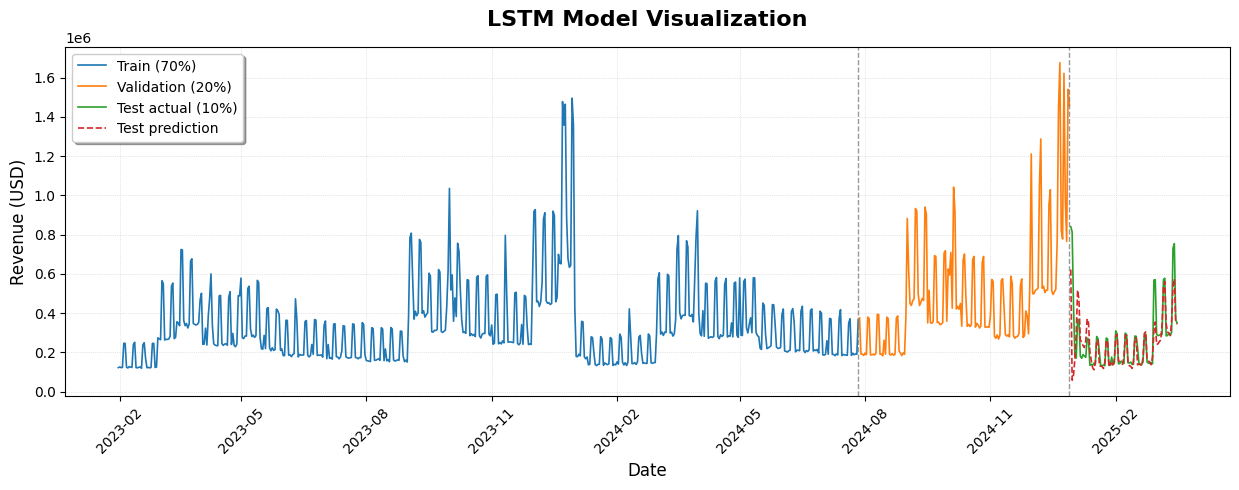

In [ ]:
# ======================= Cell 8: Visualization (Style like Image) ======================= #
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_styled_segments(ytr, yva, yte, yte_pred=None, title="LSTM Model"):
    fig, ax = plt.subplots(figsize=(12.5, 5))

    # Tính tổng số sample để đổi sang %
    total_samples = len(ytr) + len(yva) + len(yte)
    if total_samples == 0:
        raise ValueError("Tổng số sample bằng 0, không thể tính phần trăm.")

    train_pct = len(ytr) / total_samples * 100
    val_pct   = len(yva) / total_samples * 100
    test_pct  = len(yte) / total_samples * 100

    # 1. Vẽ các đường (Line Plot) với màu sắc giống hình mẫu
    # Train: Xanh dương (Blue/Tab:blue)
    ax.plot(
        ytr.index, ytr.values,
        label=f"Train ({train_pct:.0f}%)",
        color='#1f77b4', linewidth=1.2
    )

    # Validation: Cam (Orange/Tab:orange)
    ax.plot(
        yva.index, yva.values,
        label=f"Validation ({val_pct:.0f}%)",
        color='#ff7f0e', linewidth=1.2
    )

    # Test: Xanh lá (Green/Tab:green) – dữ liệu thực tế
    ax.plot(
        yte.index, yte.values,
        label=f"Test actual ({test_pct:.0f}%)",
        color='#2ca02c', linewidth=1.2
    )

    # Đường dự đoán trên tập test (Prediction)
    if yte_pred is not None:
        # Bảo đảm index thẳng hàng với yte
        if not isinstance(yte_pred, pd.Series):
            yte_pred = pd.Series(yte_pred, index=yte.index)
        else:
            yte_pred = yte_pred.reindex(yte.index)

        ax.plot(
            yte_pred.index, yte_pred.values,
            label="Test prediction",
            color='#d62728', linewidth=1.2, linestyle='--'
        )

    # 2. Đường kẻ dọc phân chia (Vertical Dashed Lines)
    if len(ytr) > 0 and len(yva) > 0:
        split_1 = ytr.index[-1]
        ax.axvline(x=split_1, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)

    if len(yva) > 0 and len(yte) > 0:
        split_2 = yva.index[-1]
        ax.axvline(x=split_2, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)

    # 3. Định dạng trục và Grid (Lưới)
    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    ax.set_ylabel("Revenue (USD)", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)

    ax.grid(which='major', linestyle=':', linewidth=0.5, alpha=0.6)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)

    ax.legend(loc="upper left", frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

# Gọi hàm vẽ – dùng thêm pte (dự đoán test) làm tham số thứ 4
plot_styled_segments(ytr, yva, yte, pte, title="LSTM Model Visualization")

